# Mask RCNN ResNet 50 (masking)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import json
import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import transforms as T
from torchvision.datasets.coco import CocoDetection
from torchvision.models.detection import maskrcnn_resnet50_fpn, FastRCNNPredictor

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as coco_mask


In [ ]:
class COCOVehicleDataset(Dataset):
    def __init__(self, img_dir, ann_path, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        self.coco = COCO(ann_path)
        self.image_ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes, labels, masks = [], [], []

        for ann in anns:
            if 'segmentation' in ann:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(1) 

                
                rle = coco_mask.frPyObjects(ann['segmentation'], img_info['height'], img_info['width'])
                mask = coco_mask.decode(rle)
                if len(mask.shape) == 3:  
                    mask = np.any(mask, axis=2).astype(np.uint8)
                masks.append(torch.as_tensor(mask, dtype=torch.uint8))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.stack(masks) if masks else torch.zeros((0, img.height, img.width), dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)


In [ ]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = maskrcnn_resnet50_fpn(weights="DEFAULT")  
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)  

model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Loding Dataset

In [23]:
from torchvision import transforms as T

def get_transform(train=True):
    return T.Compose([T.ToTensor()])


In [24]:
train_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images",
    ann_path="/kaggle/input/coco-format-seg/train_coco_with_seg.json",
    transforms=get_transform(train=True)
)

val_dataset = COCOVehicleDataset(
    img_dir="/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images",
    ann_path="/kaggle/input/coco-format-seg/val_coco_with_seg.json",
    transforms=get_transform(train=False)
)


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


## Training

In [26]:
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 50


In [ ]:
from tqdm.notebook import tqdm

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    batch_losses = []
    mask_loss_total = 0.0  

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    for images, targets in tqdm(train_loader, desc="Training", leave=False):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        
        mask_loss_total += loss_dict['loss_mask'].item()

        batch_losses.append(losses.item())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    avg_mask_loss = mask_loss_total / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {avg_loss:.4f} | Avg Mask Loss: {avg_mask_loss:.4f}")
    lr_scheduler.step()



Epoch [1/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [1/50] - Avg Loss: 0.6192 | Avg Mask Loss: 0.1952

Epoch [2/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [2/50] - Avg Loss: 0.4759 | Avg Mask Loss: 0.1580

Epoch [3/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [3/50] - Avg Loss: 0.4236 | Avg Mask Loss: 0.1437

Epoch [4/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [4/50] - Avg Loss: 0.3772 | Avg Mask Loss: 0.1321

Epoch [5/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [5/50] - Avg Loss: 0.3514 | Avg Mask Loss: 0.1249

Epoch [6/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [6/50] - Avg Loss: 0.3235 | Avg Mask Loss: 0.1174

Epoch [7/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [7/50] - Avg Loss: 0.2991 | Avg Mask Loss: 0.1098

Epoch [8/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [8/50] - Avg Loss: 0.2702 | Avg Mask Loss: 0.1036

Epoch [9/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [9/50] - Avg Loss: 0.2508 | Avg Mask Loss: 0.0973

Epoch [10/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [10/50] - Avg Loss: 0.2430 | Avg Mask Loss: 0.0943

Epoch [11/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [11/50] - Avg Loss: 0.2275 | Avg Mask Loss: 0.0889

Epoch [12/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [12/50] - Avg Loss: 0.2095 | Avg Mask Loss: 0.0846

Epoch [13/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [13/50] - Avg Loss: 0.1969 | Avg Mask Loss: 0.0808

Epoch [14/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [14/50] - Avg Loss: 0.1918 | Avg Mask Loss: 0.0779

Epoch [15/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [15/50] - Avg Loss: 0.1799 | Avg Mask Loss: 0.0751

Epoch [16/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [16/50] - Avg Loss: 0.1426 | Avg Mask Loss: 0.0668

Epoch [17/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [17/50] - Avg Loss: 0.1281 | Avg Mask Loss: 0.0630

Epoch [18/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [18/50] - Avg Loss: 0.1211 | Avg Mask Loss: 0.0608

Epoch [19/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [19/50] - Avg Loss: 0.1163 | Avg Mask Loss: 0.0598

Epoch [20/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [20/50] - Avg Loss: 0.1115 | Avg Mask Loss: 0.0583

Epoch [21/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [21/50] - Avg Loss: 0.1092 | Avg Mask Loss: 0.0579

Epoch [22/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [22/50] - Avg Loss: 0.1060 | Avg Mask Loss: 0.0571

Epoch [23/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [23/50] - Avg Loss: 0.1040 | Avg Mask Loss: 0.0564

Epoch [24/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [24/50] - Avg Loss: 0.1016 | Avg Mask Loss: 0.0555

Epoch [25/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [25/50] - Avg Loss: 0.1002 | Avg Mask Loss: 0.0551

Epoch [26/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [26/50] - Avg Loss: 0.0983 | Avg Mask Loss: 0.0548

Epoch [27/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [27/50] - Avg Loss: 0.0966 | Avg Mask Loss: 0.0540

Epoch [28/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [28/50] - Avg Loss: 0.0957 | Avg Mask Loss: 0.0539

Epoch [29/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [29/50] - Avg Loss: 0.0942 | Avg Mask Loss: 0.0537

Epoch [30/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [30/50] - Avg Loss: 0.0925 | Avg Mask Loss: 0.0531

Epoch [31/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [31/50] - Avg Loss: 0.0904 | Avg Mask Loss: 0.0526

Epoch [32/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [32/50] - Avg Loss: 0.0900 | Avg Mask Loss: 0.0523

Epoch [33/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [33/50] - Avg Loss: 0.0897 | Avg Mask Loss: 0.0523

Epoch [34/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [34/50] - Avg Loss: 0.0898 | Avg Mask Loss: 0.0524

Epoch [35/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [35/50] - Avg Loss: 0.0900 | Avg Mask Loss: 0.0527

Epoch [36/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [36/50] - Avg Loss: 0.0897 | Avg Mask Loss: 0.0523

Epoch [37/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [37/50] - Avg Loss: 0.0897 | Avg Mask Loss: 0.0527

Epoch [38/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [38/50] - Avg Loss: 0.0892 | Avg Mask Loss: 0.0524

Epoch [39/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [39/50] - Avg Loss: 0.0889 | Avg Mask Loss: 0.0522

Epoch [40/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [40/50] - Avg Loss: 0.0890 | Avg Mask Loss: 0.0524

Epoch [41/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [41/50] - Avg Loss: 0.0892 | Avg Mask Loss: 0.0523

Epoch [42/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [42/50] - Avg Loss: 0.0890 | Avg Mask Loss: 0.0524

Epoch [43/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [43/50] - Avg Loss: 0.0894 | Avg Mask Loss: 0.0525

Epoch [44/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [44/50] - Avg Loss: 0.0891 | Avg Mask Loss: 0.0521

Epoch [45/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [45/50] - Avg Loss: 0.0888 | Avg Mask Loss: 0.0522

Epoch [46/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [46/50] - Avg Loss: 0.0885 | Avg Mask Loss: 0.0521

Epoch [47/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [47/50] - Avg Loss: 0.0881 | Avg Mask Loss: 0.0522

Epoch [48/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [48/50] - Avg Loss: 0.0885 | Avg Mask Loss: 0.0521

Epoch [49/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [49/50] - Avg Loss: 0.0882 | Avg Mask Loss: 0.0520

Epoch [50/50]


Training:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch [50/50] - Avg Loss: 0.0880 | Avg Mask Loss: 0.0519


In [ ]:
torch.save(model.state_dict(), "mrcnnres50mask_vehicle_detector.pth") #save model

## Evaluation

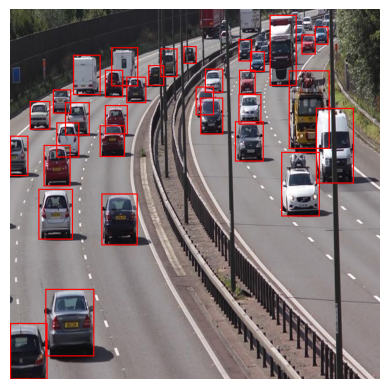

In [29]:
from PIL import ImageDraw

def infer_and_show(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    image_draw = image.copy()
    draw = ImageDraw.Draw(image_draw)

    for box, score in zip(prediction["boxes"], prediction["scores"]):
        if score > 0.5:
            x1, y1, x2, y2 = box.cpu().numpy().astype(int)
            draw.rectangle(((x1, y1), (x2, y2)), outline="red", width=2)

    plt.imshow(image_draw)
    plt.axis("off")
    plt.show()

infer_and_show("/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images/10_mp4-25_jpg.rf.11c919cc683cc6a0d0a658be13483748.jpg")


In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2) 

model.load_state_dict(torch.load("/kaggle/working/mrcnnres50mask_vehicle_detector.pth"))
model.to(device)
model.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
def count_vehicles(image_path):
    from PIL import Image, ImageDraw
    import torchvision.transforms.functional as F

    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    vehicle_count = sum(score.item() > 0.5 for score in prediction['scores'])
    print(f"🚌 Detected {vehicle_count} vehicles in image: {os.path.basename(image_path)}")

    draw = ImageDraw.Draw(image)
    for box, score in zip(prediction['boxes'], prediction['scores']):
        if score > 0.5:
            x1, y1, x2, y2 = box.int().tolist()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    display(image)


🚌 Detected 3 vehicles in image: 6_mp4-14_jpg.rf.a5099c3eeb2c707a2193c0efa467bb2a.jpg


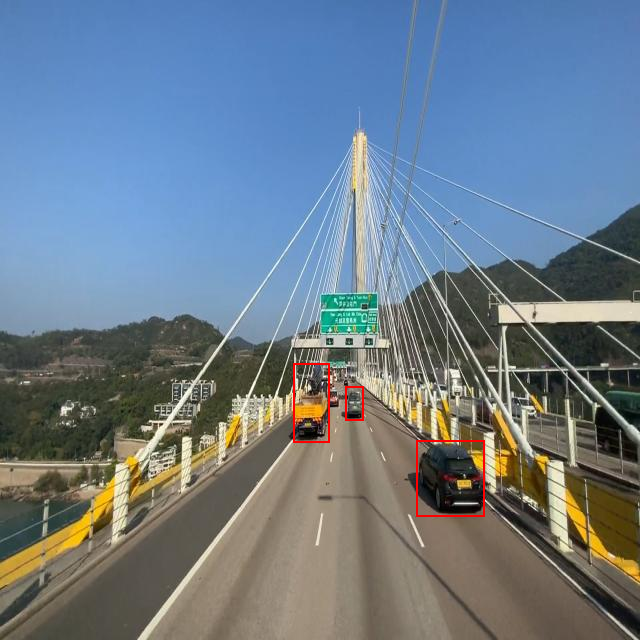

🚌 Detected 28 vehicles in image: 10_mp4-39_jpg.rf.af70092b5f2277f16d2703a4d59c3313.jpg


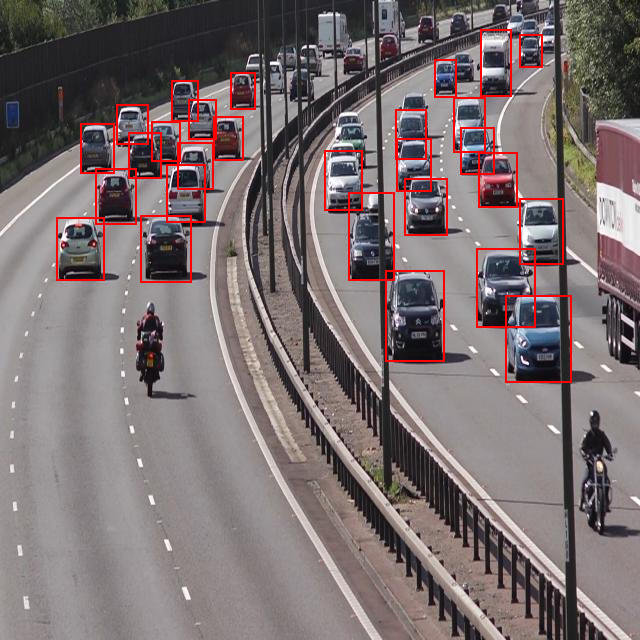

🚌 Detected 21 vehicles in image: 8_mp4-39_jpg.rf.bf01d183fca62e3316a0e4b31bfdf0da.jpg


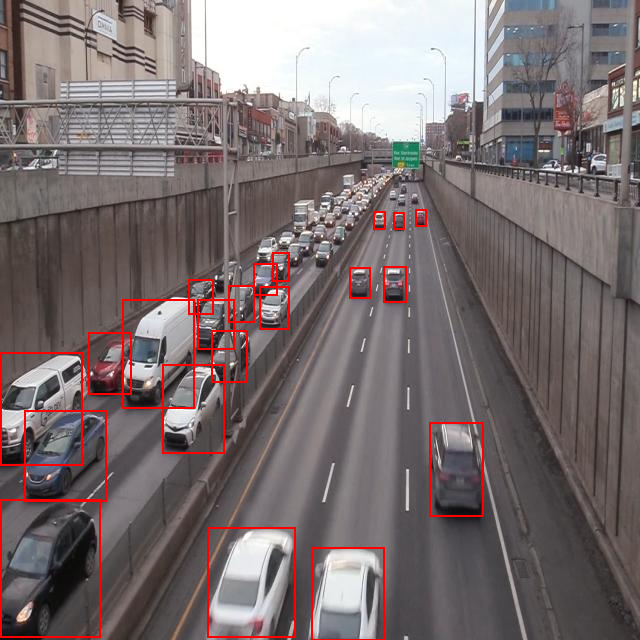

🚌 Detected 1 vehicles in image: 3_mp4-14_jpg.rf.6597c5732e0d554f1f07edb59abb4f8b.jpg


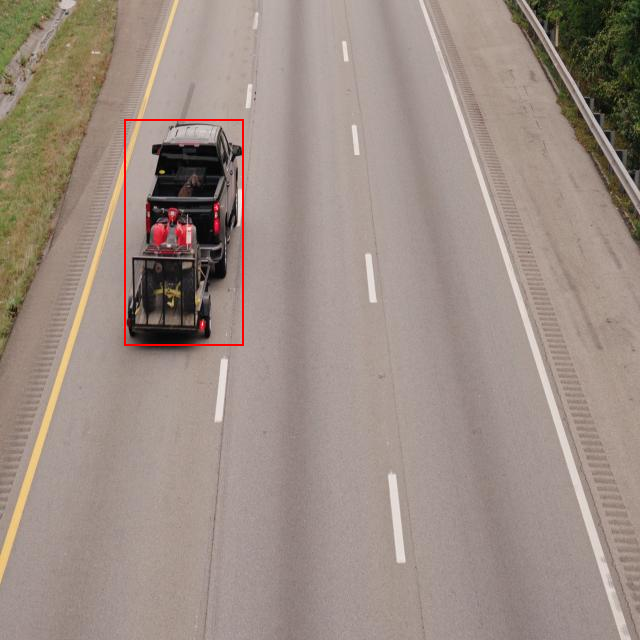

🚌 Detected 20 vehicles in image: test2_mp4-8_jpg.rf.c10dd559d44a868fd6f6877fd734815a.jpg


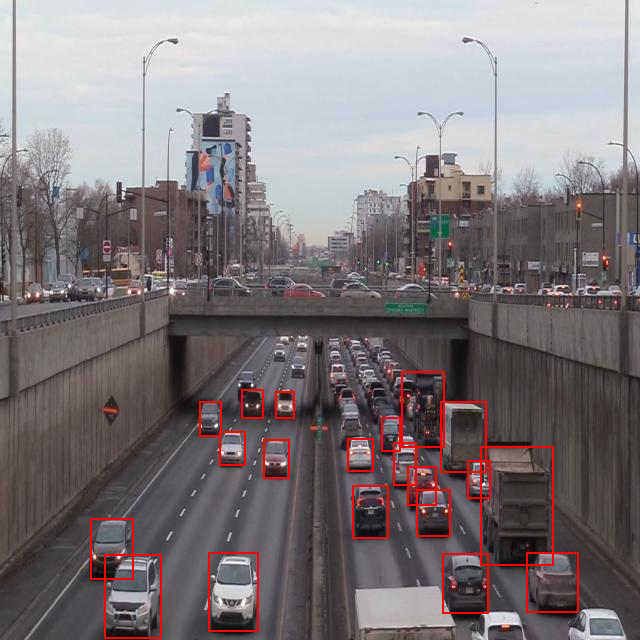

In [ ]:
val_image_dir = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
for fname in os.listdir(val_image_dir)[20:25]:  
    count_vehicles(os.path.join(val_image_dir, fname))


## Metrics

In [ ]:
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH  = "/kaggle/working/mrcnnres50mask_vehicle_detector.pth"
IMG_DIR     = "/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images"
ANN_PATH    = "/kaggle/input/coco-format/val_coco.json"
CONF_THRESH = 0.5

model = maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(DEVICE).eval()

coco_gt   = COCO(ANN_PATH)
img_ids   = coco_gt.getImgIds()
cat_ids   = coco_gt.getCatIds()
CAT_ID    = cat_ids[0]

to_tensor = T.ToTensor()
preds = []

for img_id in img_ids:
    info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(IMG_DIR, info["file_name"])
    img = Image.open(img_path).convert("RGB")
    tensor = to_tensor(img).to(DEVICE).unsqueeze(0)

    with torch.no_grad():
        out = model(tensor)[0]

    boxes  = out["boxes"].cpu().numpy()
    scores = out["scores"].cpu().numpy()

    for box, score in zip(boxes, scores):
        if score < CONF_THRESH:
            continue
        x1, y1, x2, y2 = box
        preds.append({
            "image_id":    img_id,
            "category_id": CAT_ID,
            "bbox":        [float(x1), float(y1), float(x2-x1), float(y2-y1)],
            "score":       float(score)
        })

with open("predictions.json", "w") as f:
    json.dump(preds, f)

coco_dt    = coco_gt.loadRes("predictions.json")
coco_eval  = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.669
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.924
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.868
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.705
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.825
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
import cv2
import torch
from torchvision import transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image


DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH  = "/kaggle/input/maskrcnn/pytorch/default/1/maskrcnn_vehicle_detector.pth"  
VIDEO_IN    = "/kaggle/input/vidtryyy/56310-479197605_small.mp4"
VIDEO_OUT   = "output_maskrcnn.mp4"
CONF_THRESH = 0.3

model = maskrcnn_resnet50_fpn(pretrained=False)
in_f = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_f, num_classes=2) 
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

cap = cv2.VideoCapture(VIDEO_IN)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS) or 30.0

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out    = cv2.VideoWriter(VIDEO_OUT, fourcc, fps, (width, height))


to_tensor = T.ToTensor()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break


    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    tensor = to_tensor(pil).to(DEVICE).unsqueeze(0)

 
    with torch.no_grad():
        out_dict = model(tensor)[0]

    boxes  = out_dict["boxes"].cpu().numpy()
    scores = out_dict["scores"].cpu().numpy()


    count = 0
    for box, score in zip(boxes, scores):
        if score < CONF_THRESH:
            continue
        count += 1
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,0,255), 2)
        cv2.putText(frame,
                    f"{score:.2f}",
                    (x1, y1-6),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (0,0,255),
                    1,
                    cv2.LINE_AA)

  
    cv2.rectangle(frame, (5,5), (140,35), (0,0,0), -1)
    cv2.putText(frame,
                f"Vehicles: {count}",
                (10,25),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (255,255,255),
                2,
                cv2.LINE_AA)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

print("✅ Done! Saved as:", VIDEO_OUT)


✅ Done! Saved as: output_maskrcnn.mp4


## Thank You!